In [1]:
from calculating_risk_for_single_community import calculating_risk_for_single_community as single_calculate
import numpy as np
import pandas as pd
import math

population = pd.read_csv('processed_population.csv')
infection = pd.read_csv('county_storage.csv')
risk_usc = pd.read_csv('risk_USC.csv')
# risk_lmu = pd.read_csv('risk_LMU_with_eval.csv')

In [2]:
'''
1) Daily new cases
2) Model outputs
3) Convert to Z-scores
4) MultiLinear Weighted Ensemble
5) Voting Regress if possible
'''

'\n1) Daily new cases\n2) Model outputs\n3) Convert to Z-scores\n4) MultiLinear Weighted Ensemble\n5) Voting Regress if possible\n'

In [3]:
# Get Neighborhood Level population, and new cases with name and date
infection['location'] = infection.apply(lambda x: x['location'].replace('UNINCORPORATED - ','').lower().replace('city of ',''), axis = 1)
infection
population2 = pd.read_csv('processed_population.csv')
population2


,Region,Latitude,Longitude,Population
0,Northridge,34.234561,-118.536932,67755
1,Exposition Park,34.013654,-118.287211,45190
2,Norwalk,33.909280,-118.084917,104868
3,Hawthorne,33.918859,-118.348326,114032
4,El Segundo,33.917028,-118.415634,26864
...,...,...,...,...
163,Claremont,34.096676,-117.719778,36850
164,Tarzana,34.171444,-118.542979,30227
165,South Park,34.040407,-118.266538,39093
166,Eagle Rock,34.138897,-118.213962,39175


In [4]:
count = 0
for index, row in population2.iterrows():
    popl = row['Population']
    loc = row['Region']
    data = infection[infection['location'] == loc.lower()]
    if len(data)>0:
        count += 1
        #if count<=78:
        #    continue
        vec = list(data['cases'])
        vec = np.array(list(filter(lambda a: a != '--', vec)),dtype = 'float')
        risk_score = single_calculate(vec, popl, 1/7.5, 1)
        model_results = pd.DataFrame([{'location':loc,'population':popl,'cases':list(vec),'risk_score':list(risk_score),'last_date':max(data['Date'])}])
        model_results.to_csv('retrain_model_results_USC.csv', mode = 'a', index = False, header = False)
        if count<10:
            print (loc+'      '+str(count))

Norwalk      1
Hawthorne      2
El Segundo      3
Glendale      4
Huntington Park      5
Culver City      6
Del Rey      7
Inglewood      8
Rancho Palos Verdes      9


In [5]:
# Organize all model outputs to the format as location;localpop;cases;risk;last_date

In [30]:
# Descriptive Statistics of 2 Z-scored variables
import matplotlib.pyplot as plt

# Show statistics of the data
def desc_var(np_var1,np_var2):
    
    # plot each one
    bins = np.linspace(-3,3,30)
    plt.hist(np_var1,bins,alpha=0.5, label='x')
    plt.hist(np_var2,bins,alpha=0.5, label='y')
    plt.legend(loc='upper right')
    plt.show()
    
    # plot
    plt.scatter(np_var1, np_var2)
    plt.show()
       
    return 

In [31]:
# Error Calculation Function

def cal_error(n_ahead, case, risk):
    n = len(case)
    new_infe = []
    risk_infe = []
    for i in range(n-n_ahead):
        new_infe.append(case[i+n_ahead]-case[i])
        risk_infe.append(risk[i])
    new_infe = (np.array(new_infe)-np.mean(new_infe)) / np.std(new_infe)
    risk_infe = (np.array(risk_infe)-np.mean(risk_infe)) / np.std(risk_infe)
    
    # You can plot the z-scores of the new infections vs risk score
    # desc_var(new_infe,risk_infe)
    return np.corrcoef(new_infe, risk_infe)[0,1]

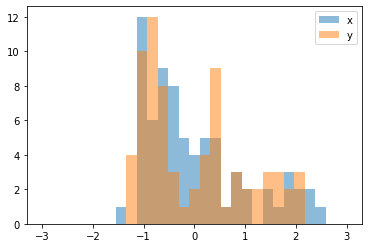

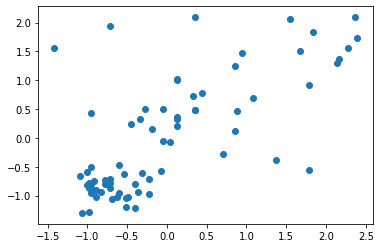

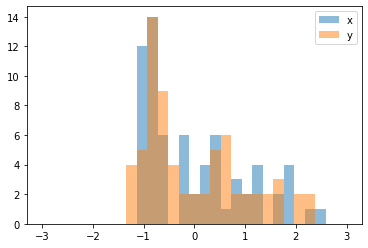

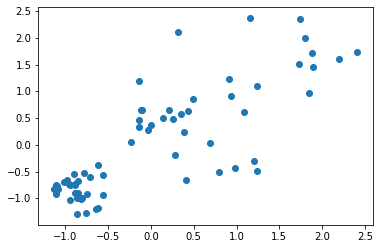

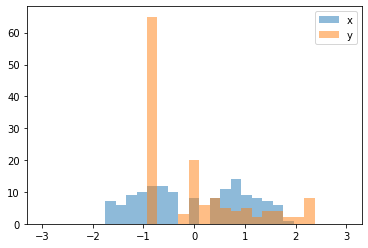

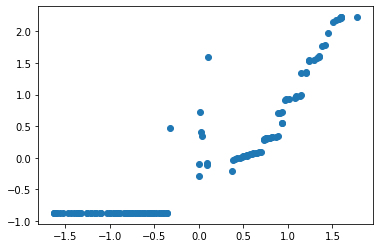

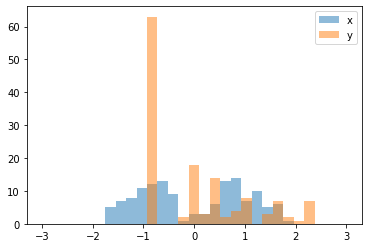

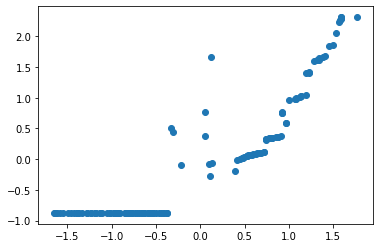

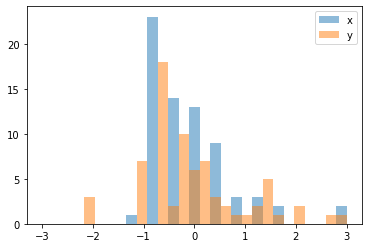

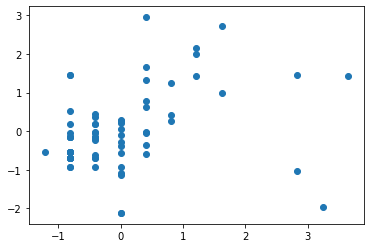

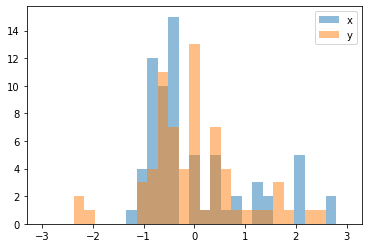

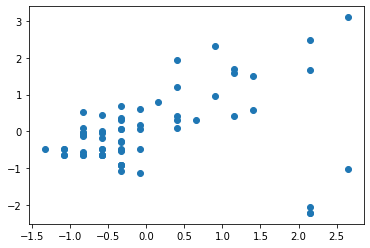

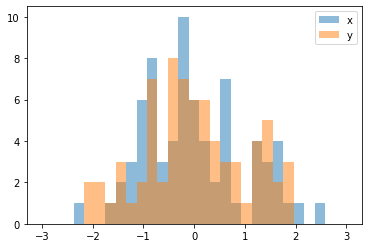

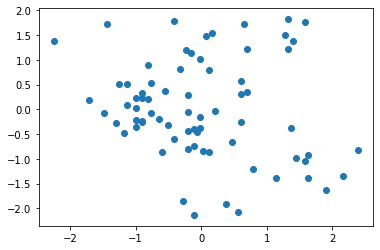

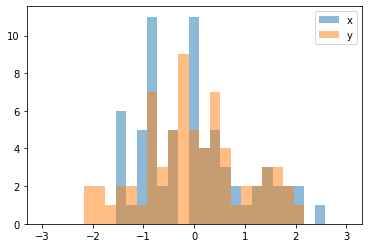

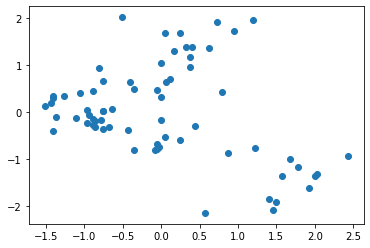

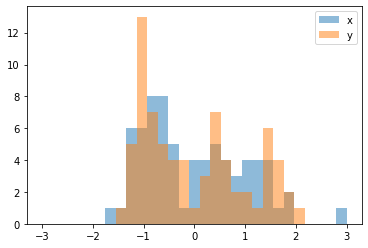

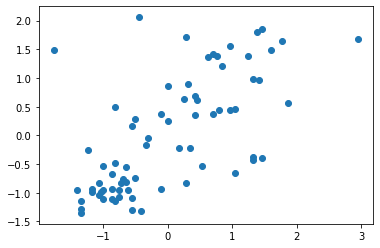

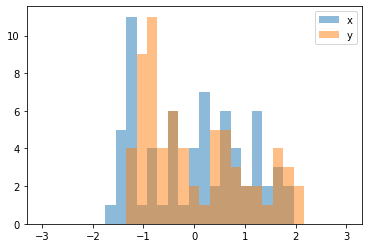

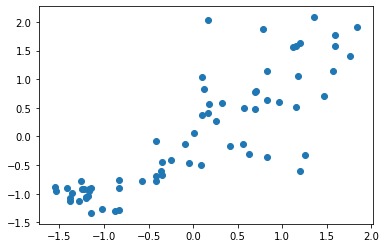

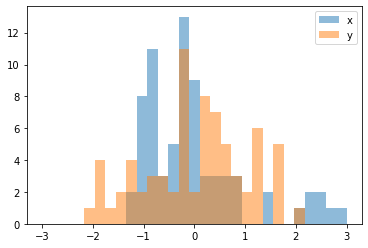

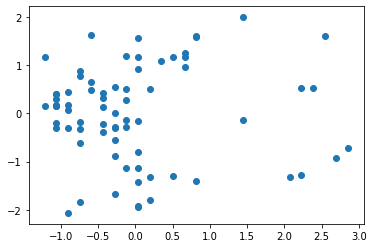

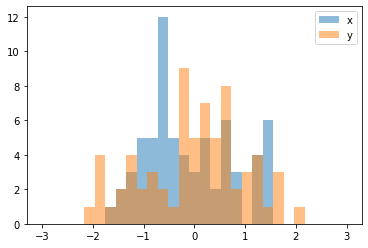

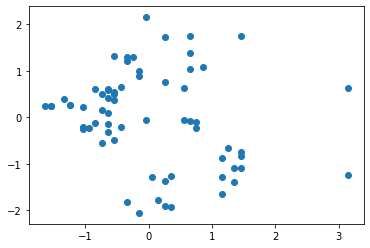

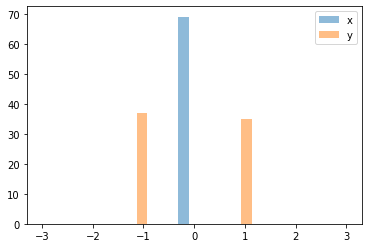

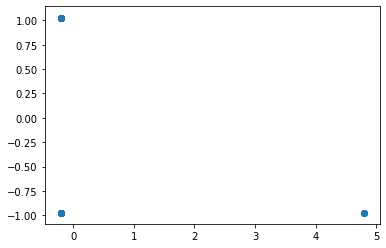

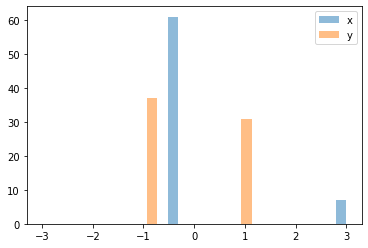

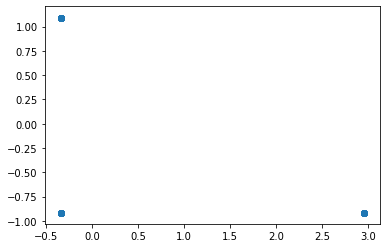

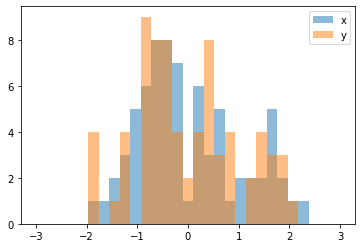

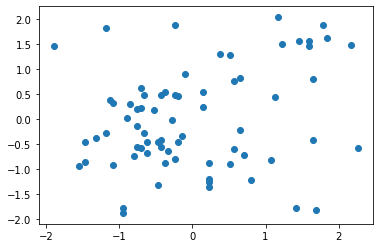

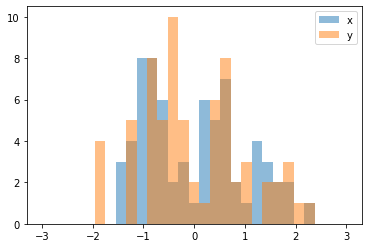

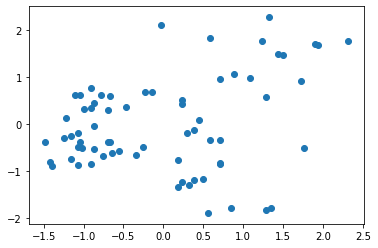

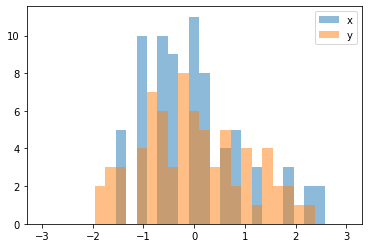

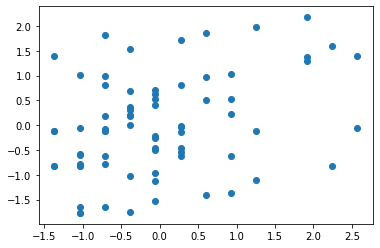

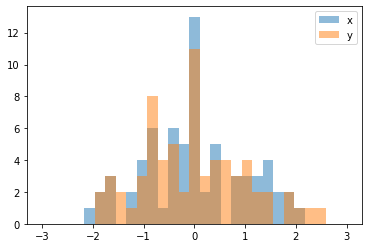

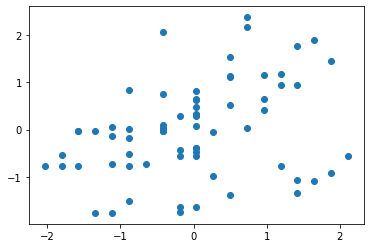

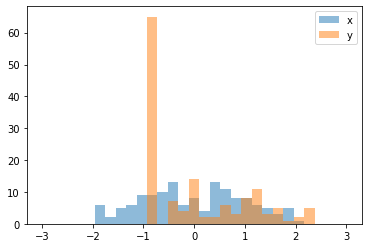

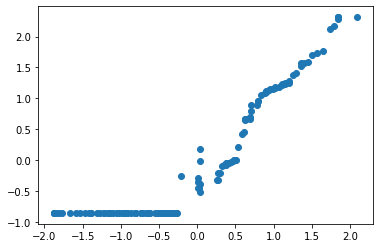

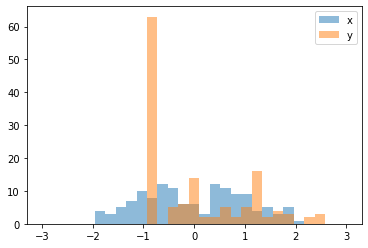

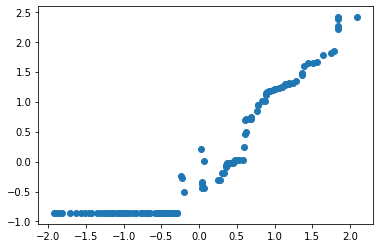

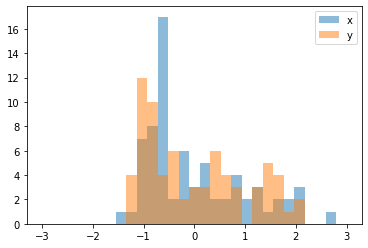

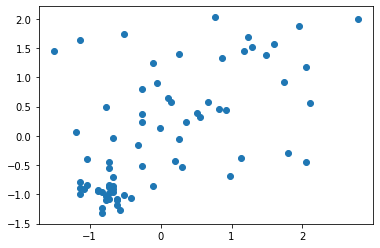

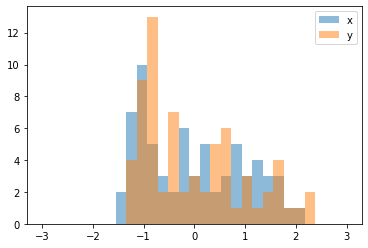

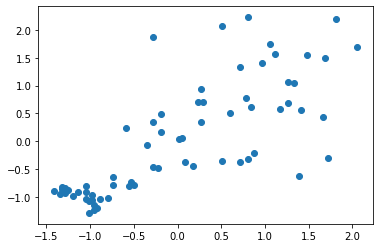

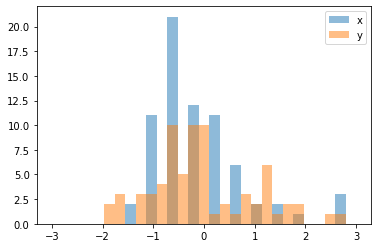

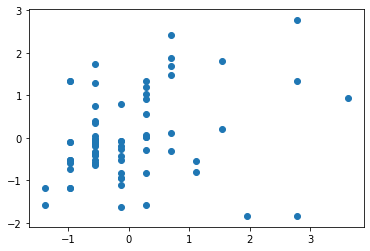

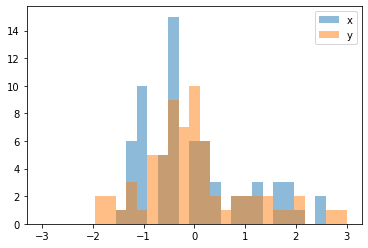

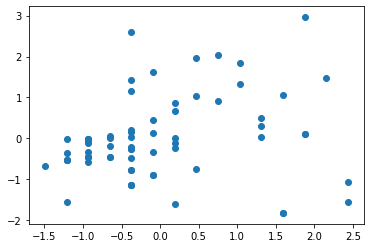

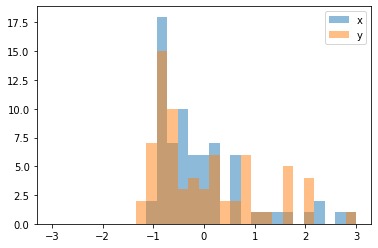

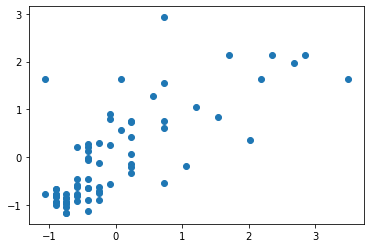

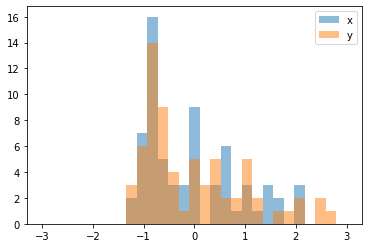

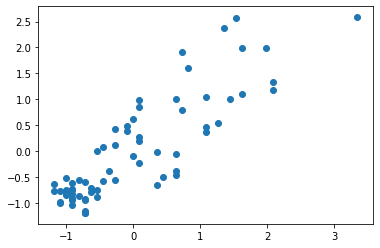

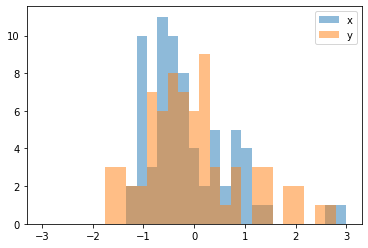

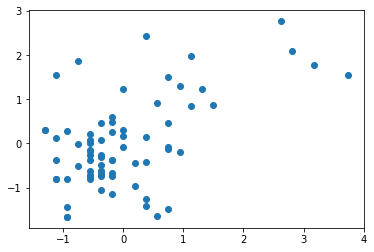

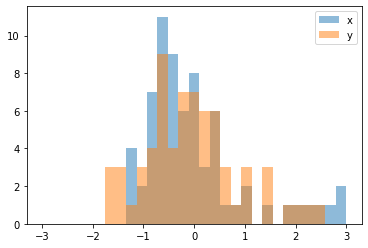

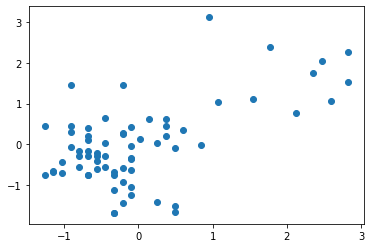

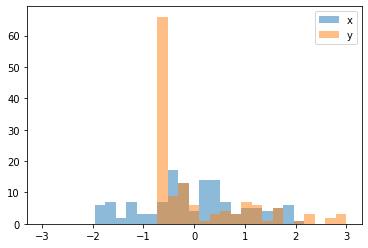

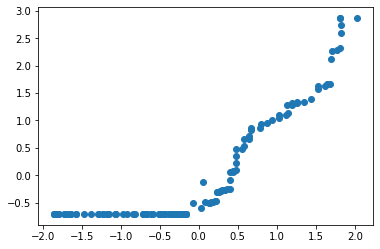

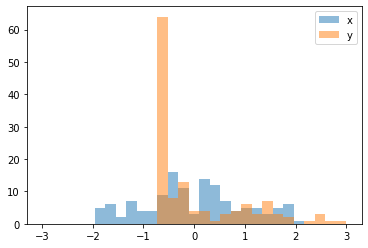

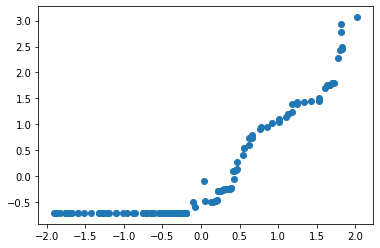

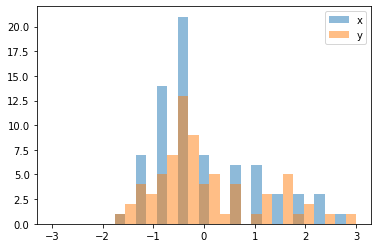

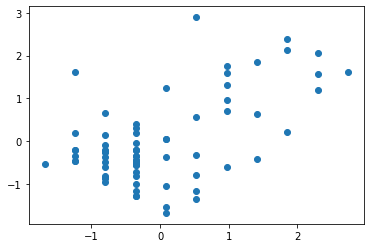

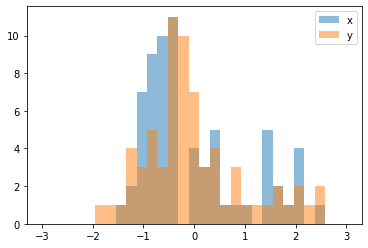

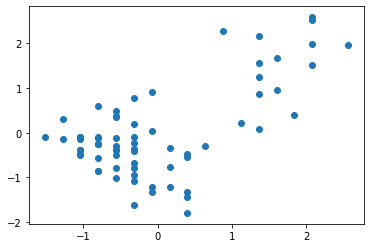

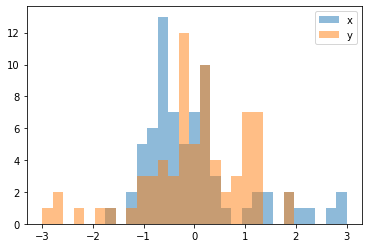

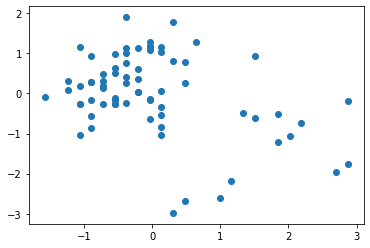

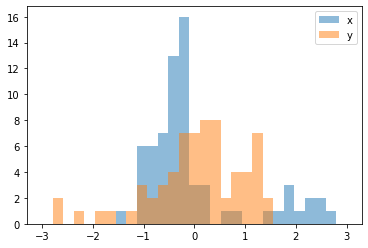

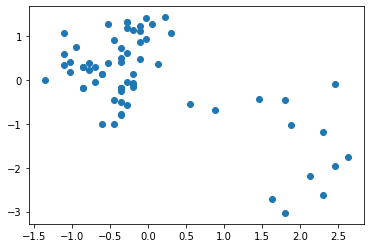

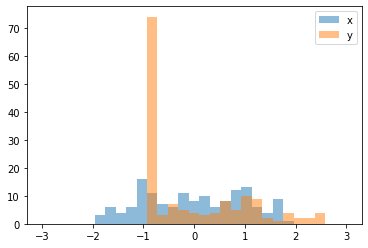

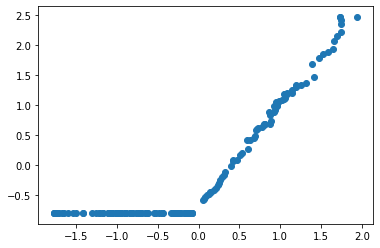

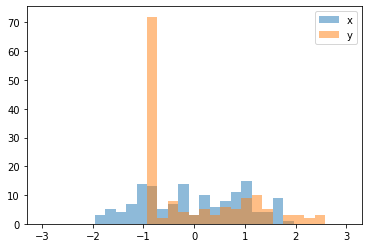

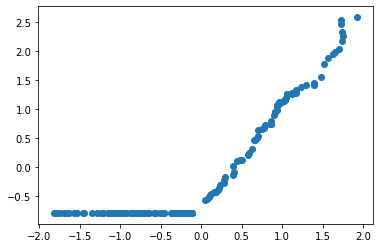

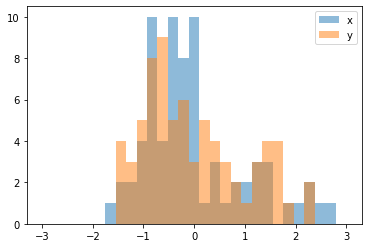

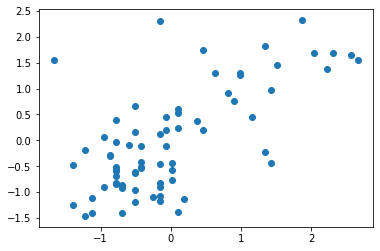

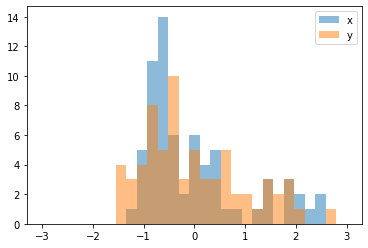

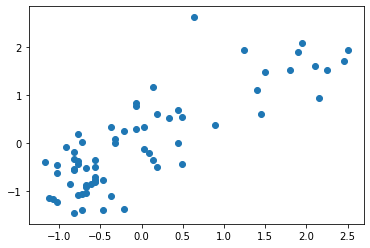

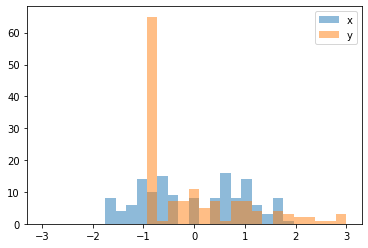

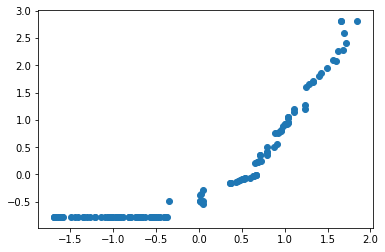

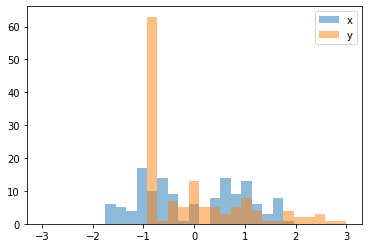

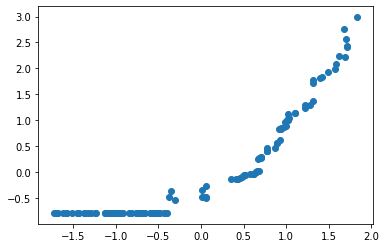

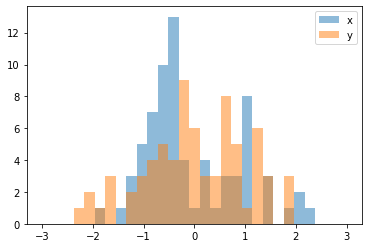

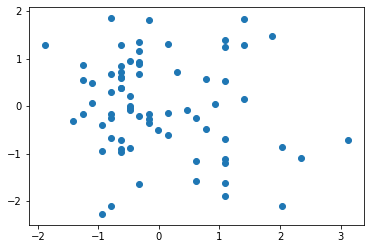

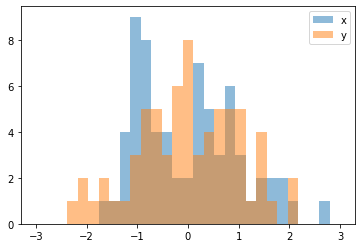

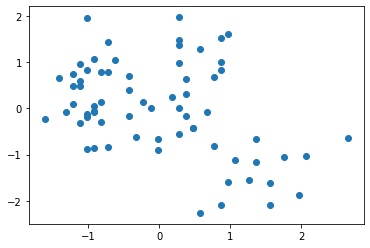

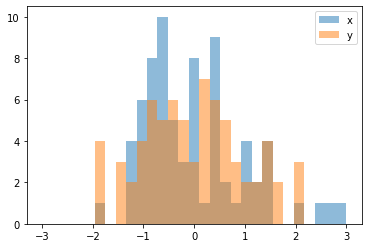

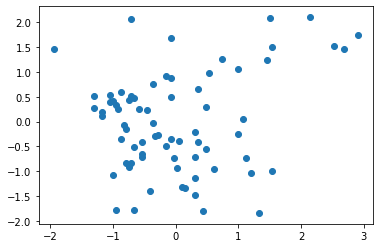

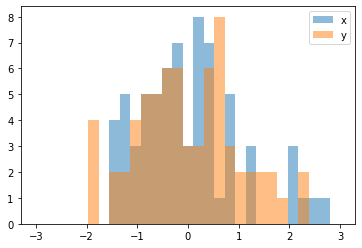

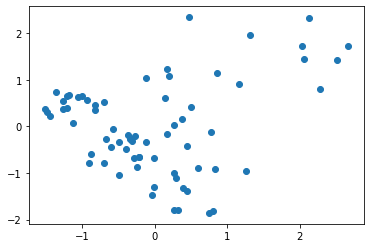

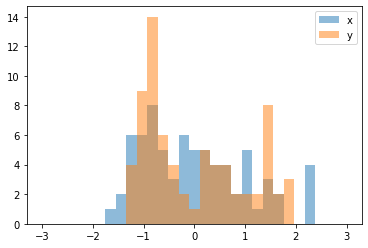

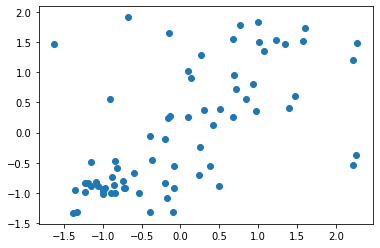

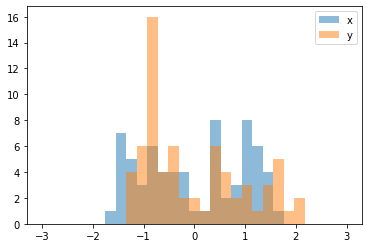

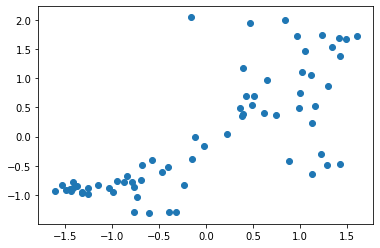

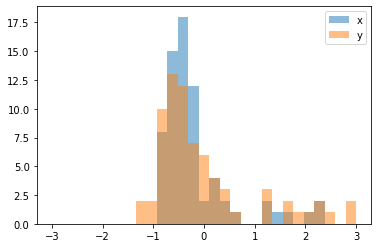

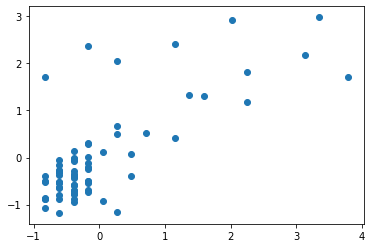

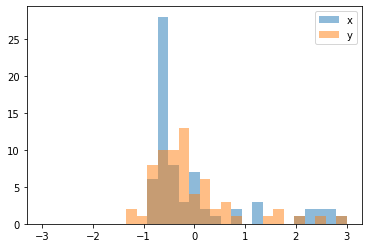

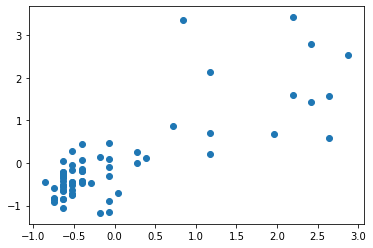

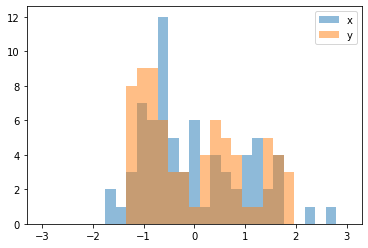

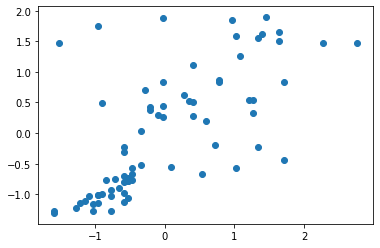

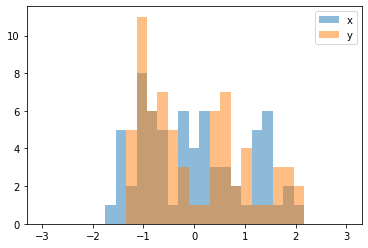

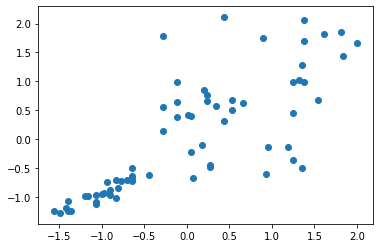

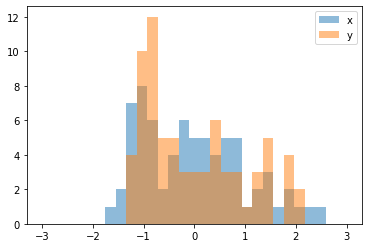

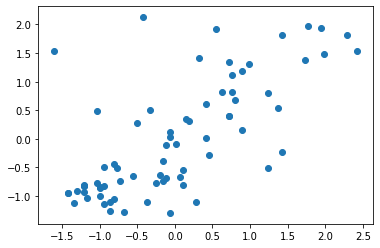

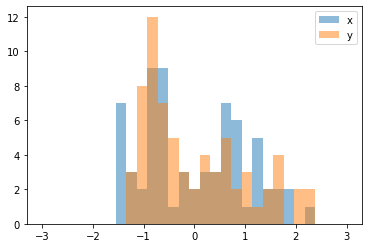

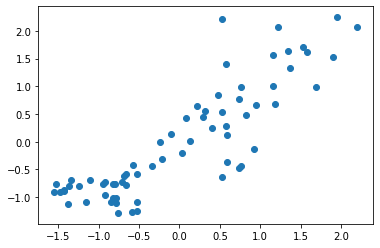

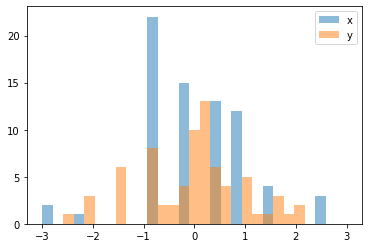

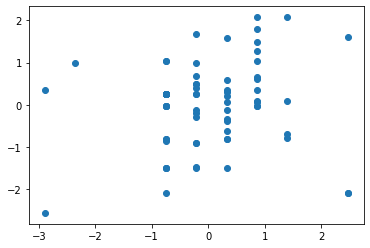

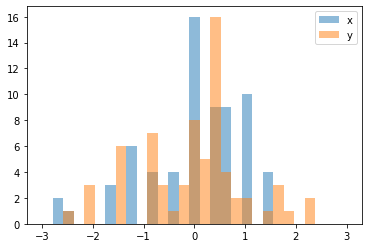

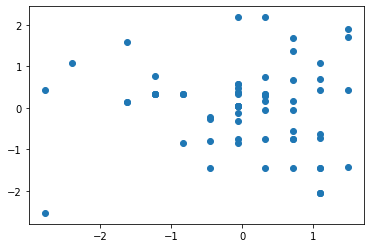

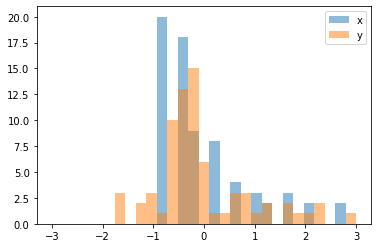

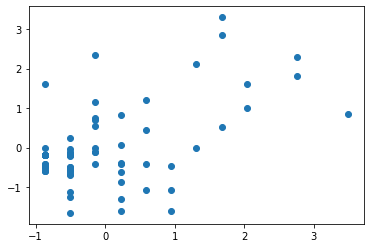

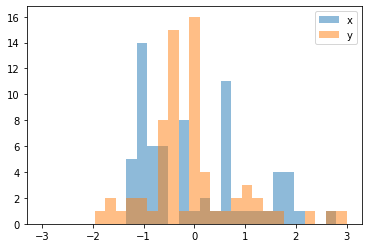

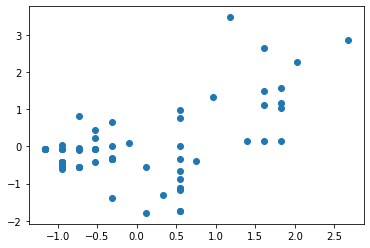

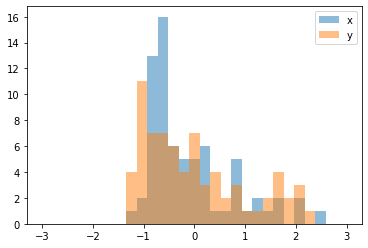

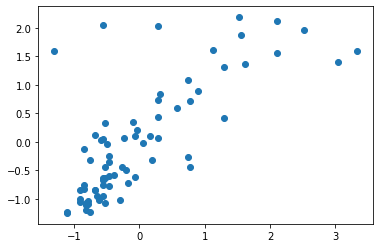

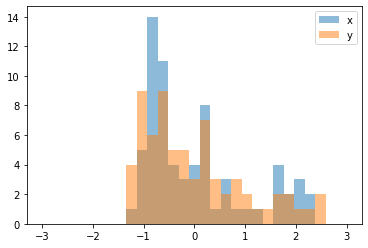

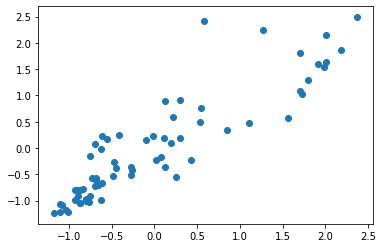

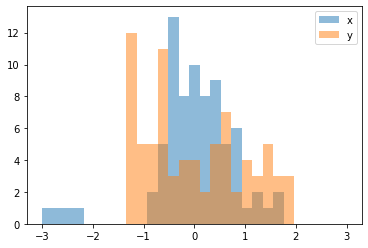

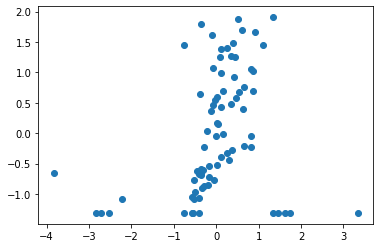

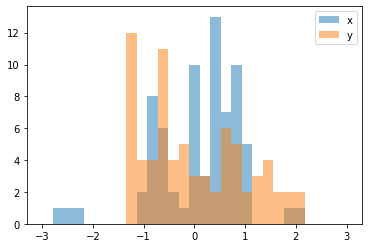

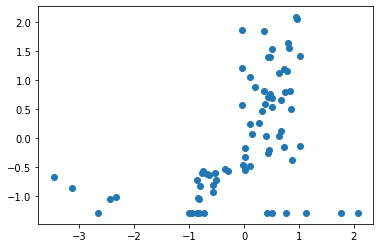

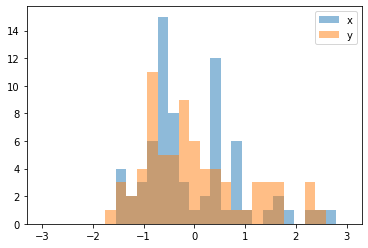

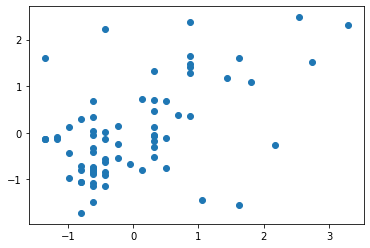

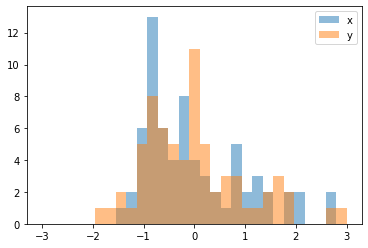

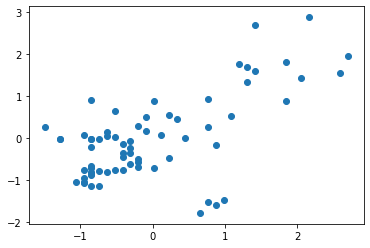

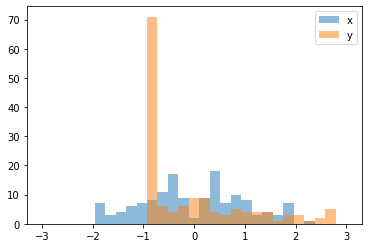

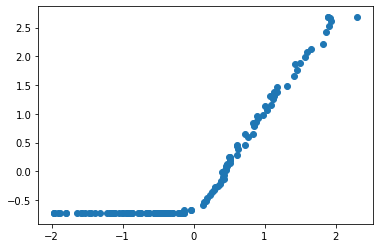

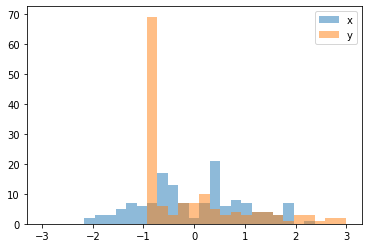

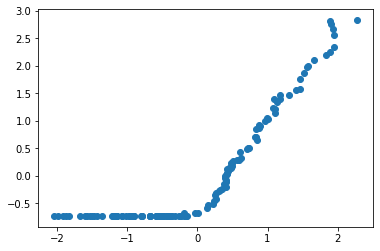

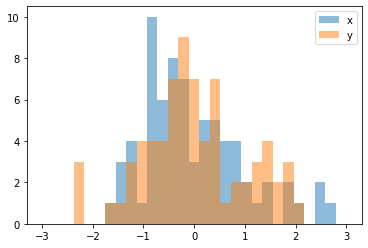

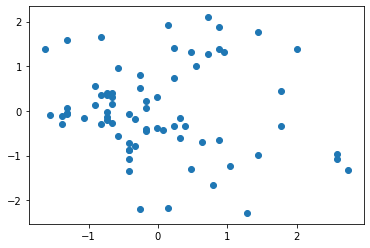

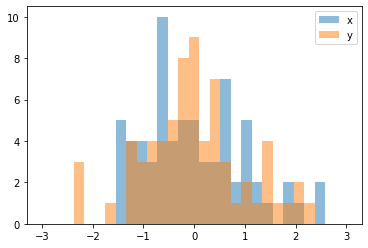

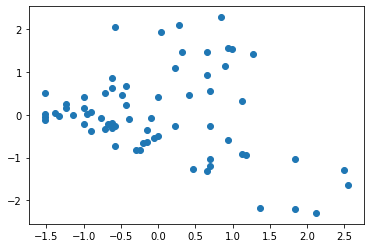

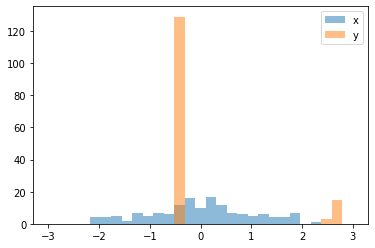

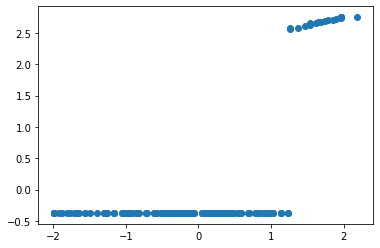

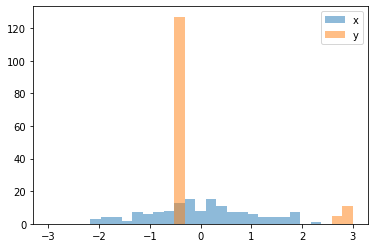

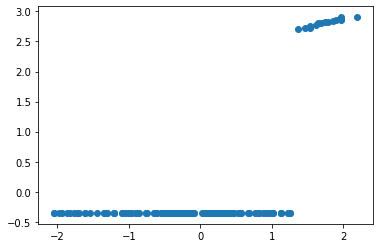

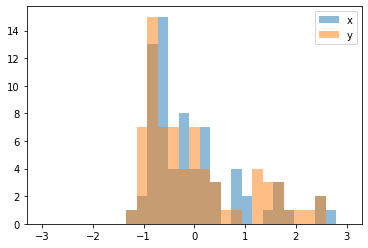

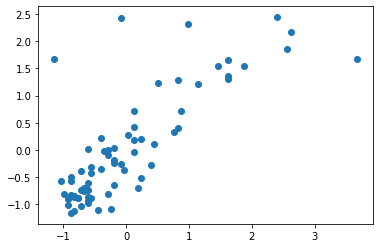

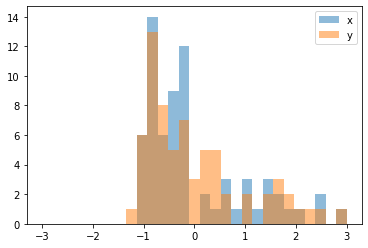

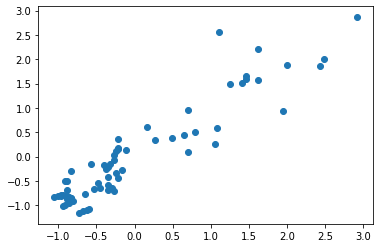

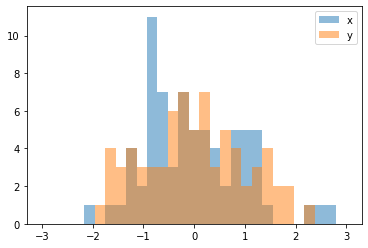

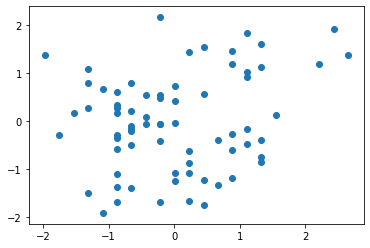

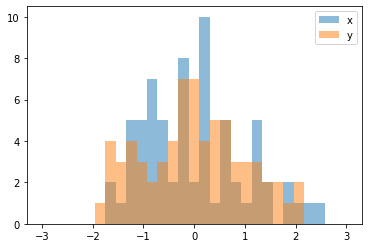

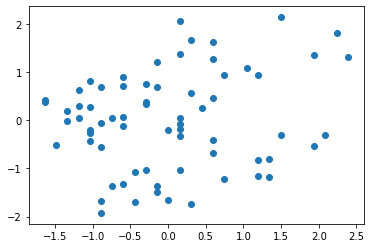

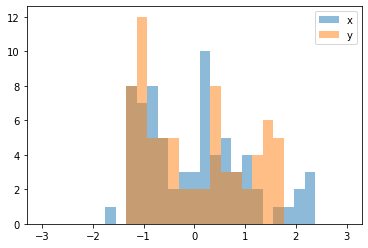

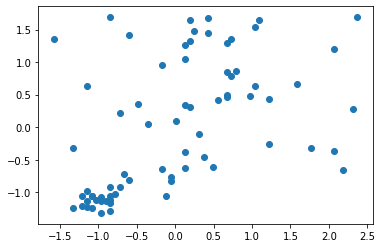

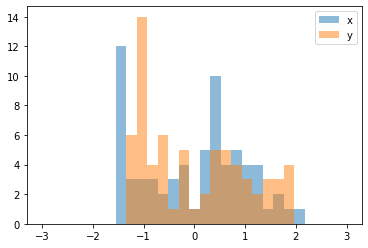

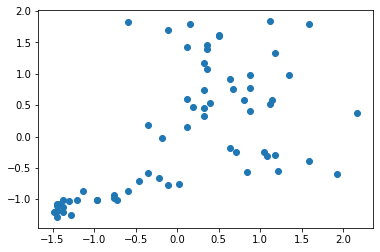

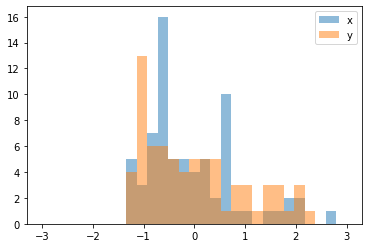

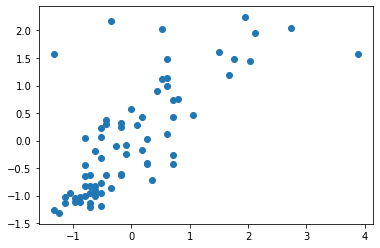

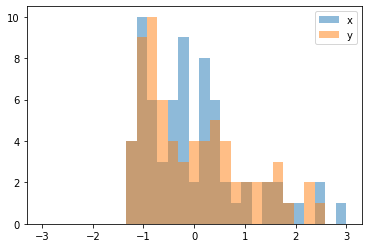

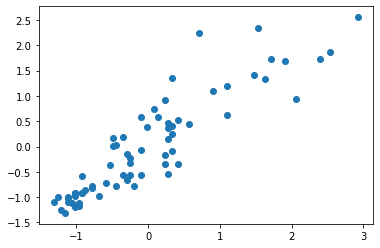

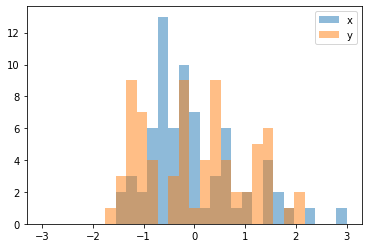

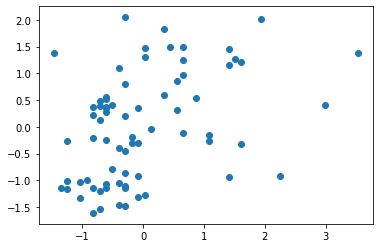

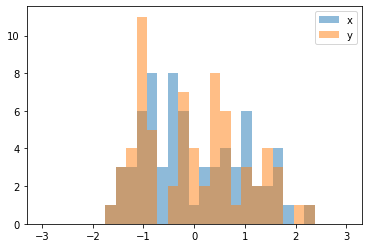

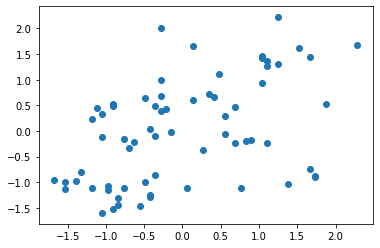

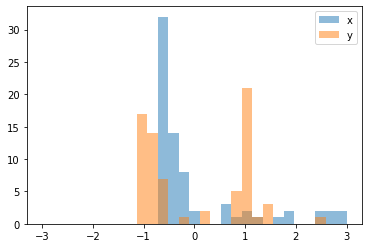

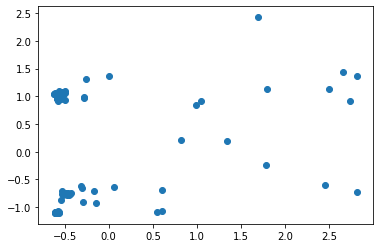

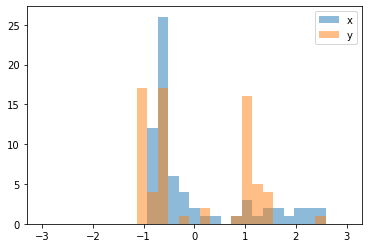

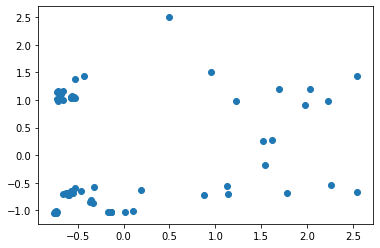

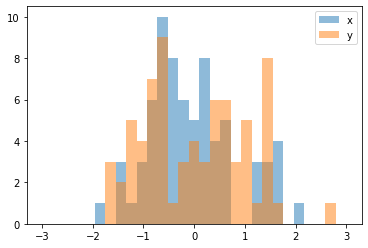

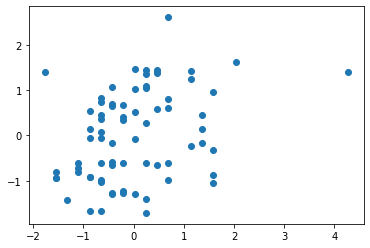

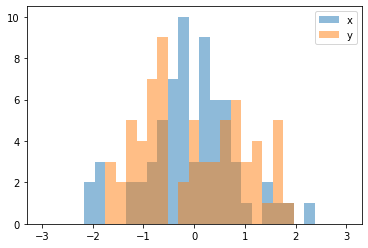

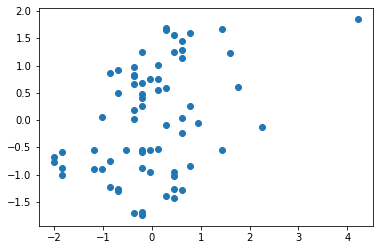

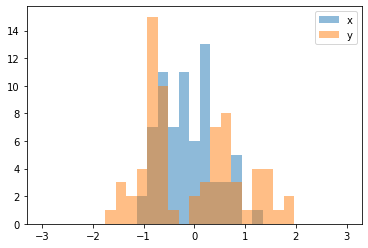

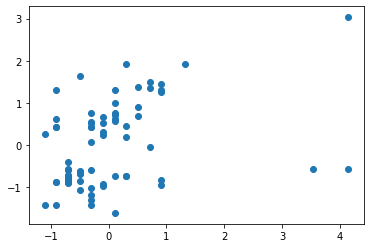

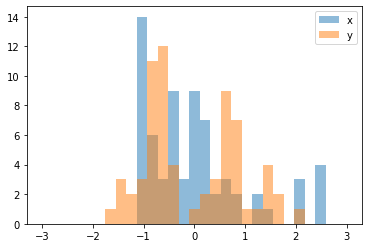

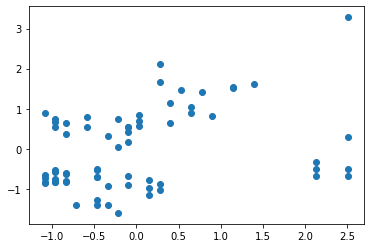

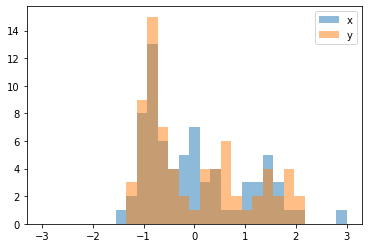

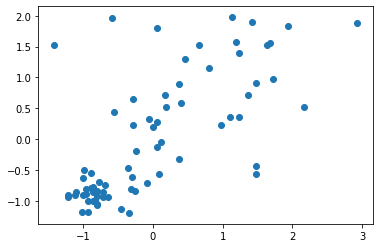

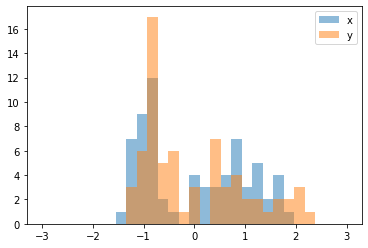

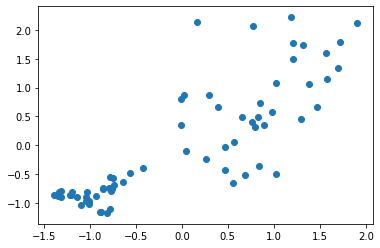

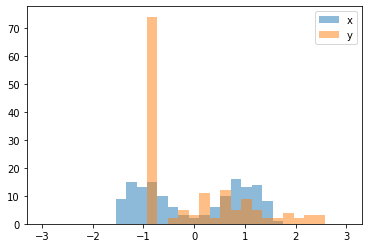

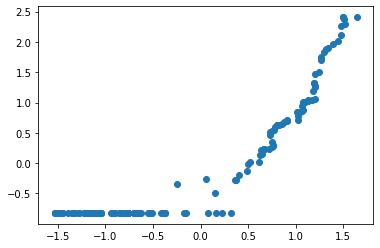

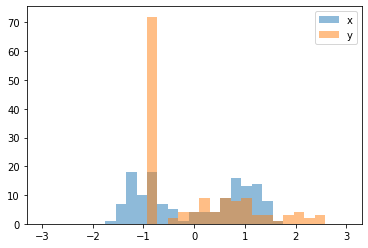

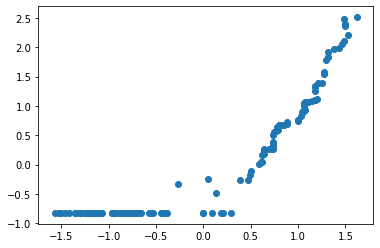

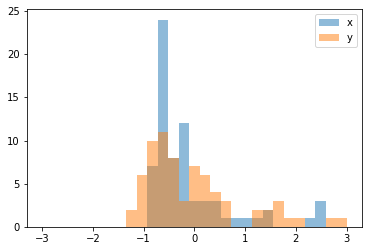

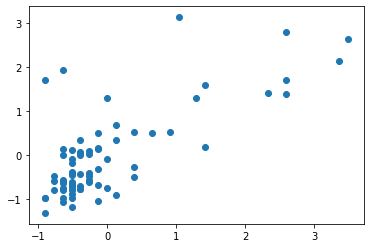

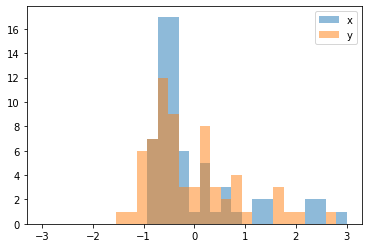

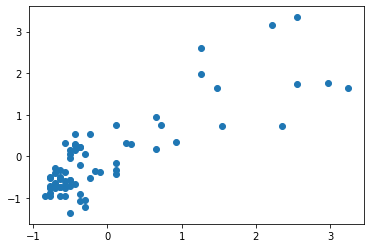

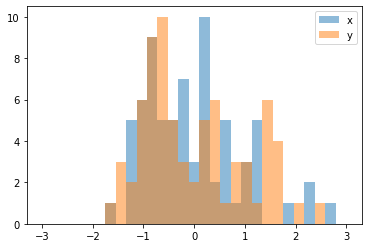

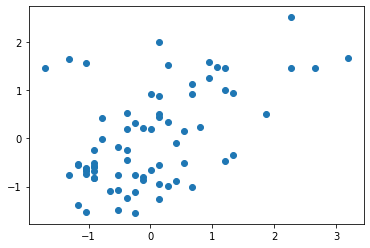

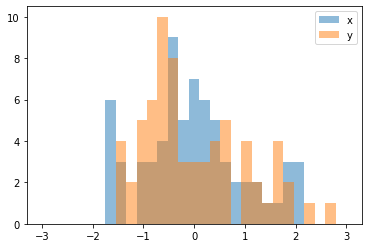

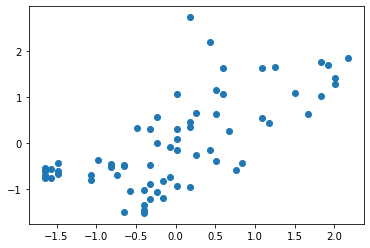

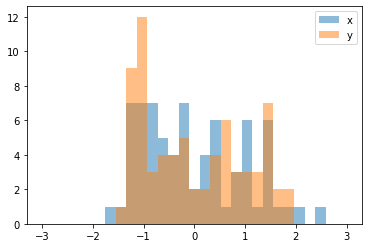

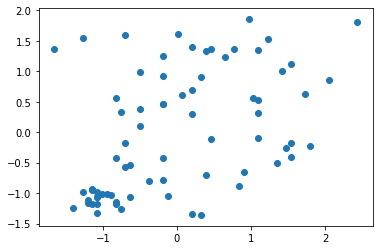

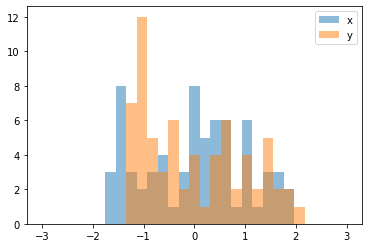

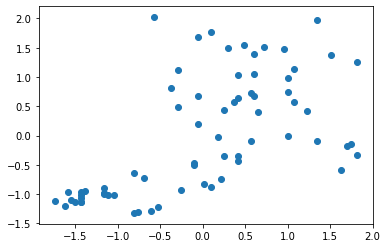

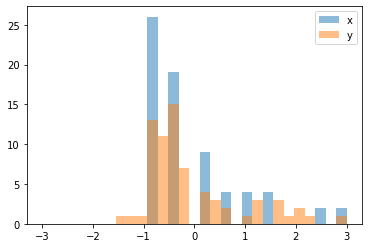

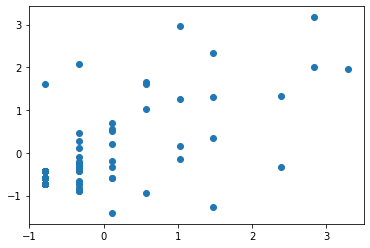

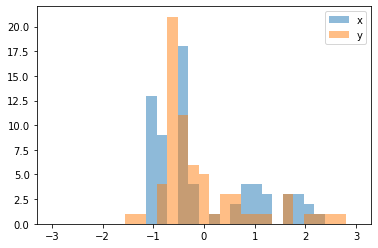

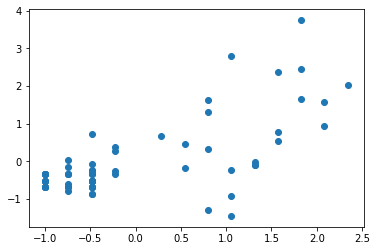

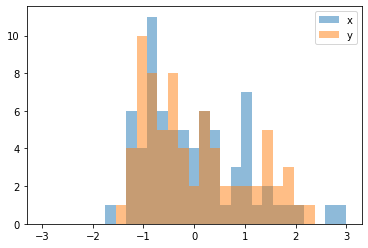

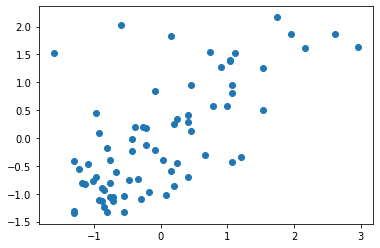

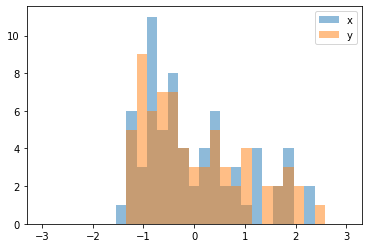

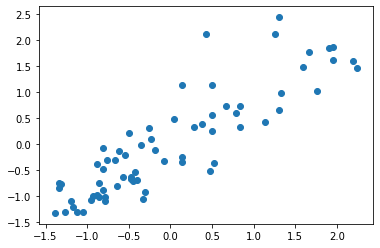

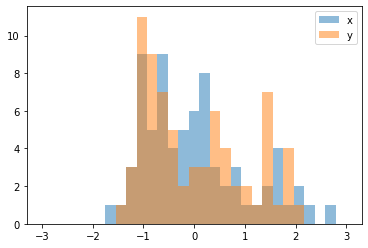

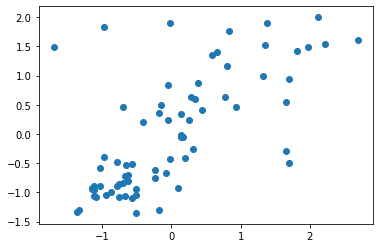

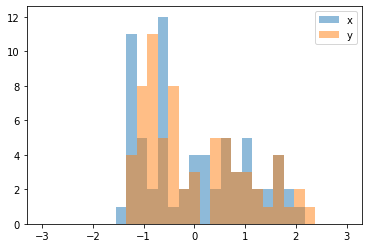

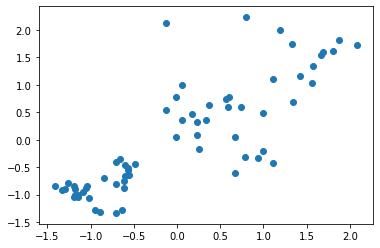

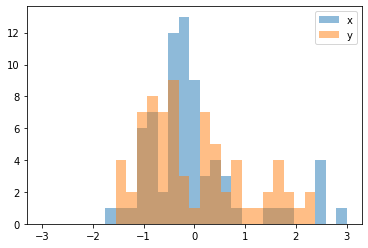

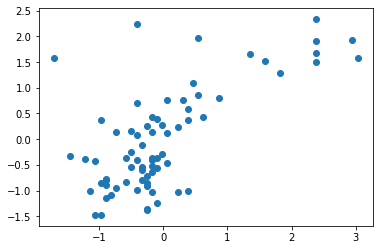

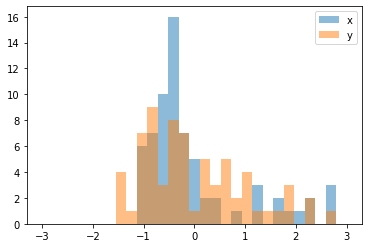

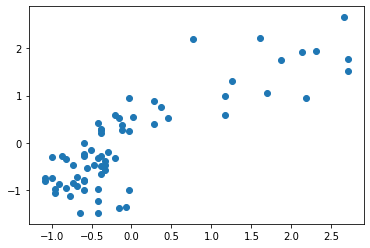

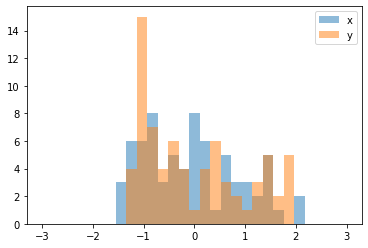

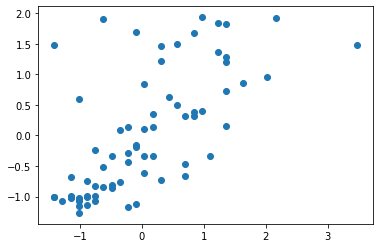

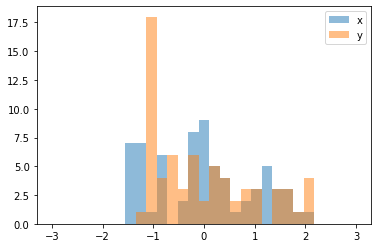

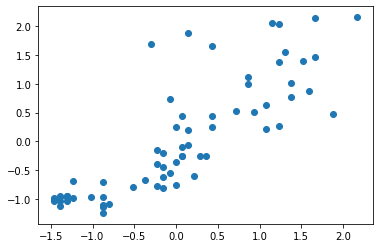

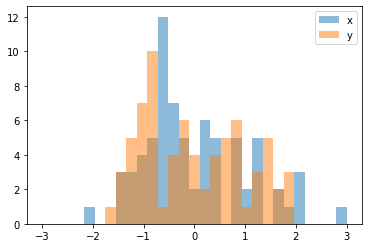

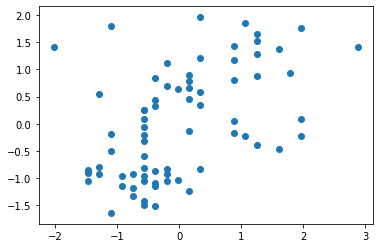

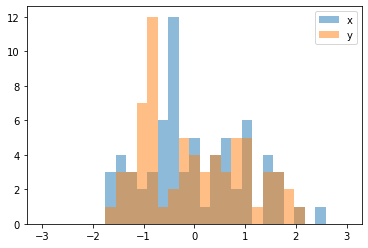

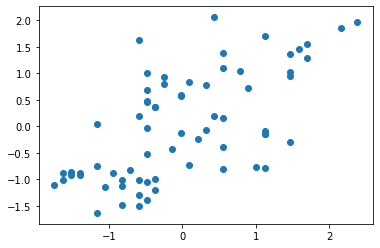

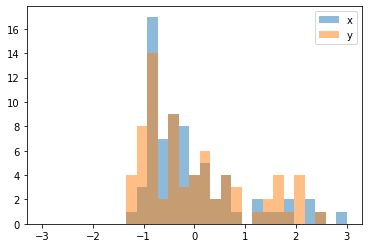

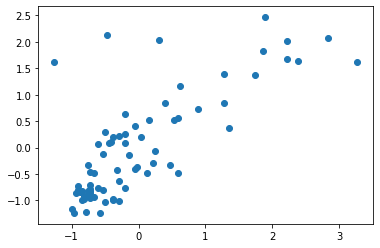

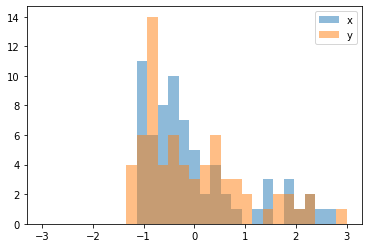

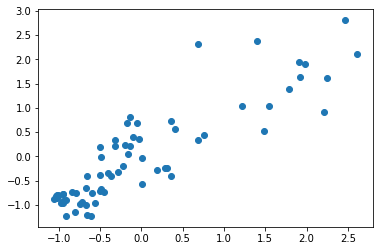

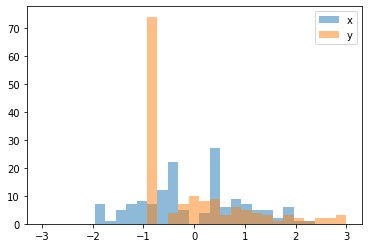

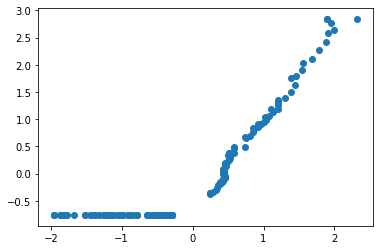

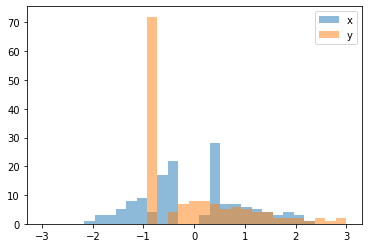

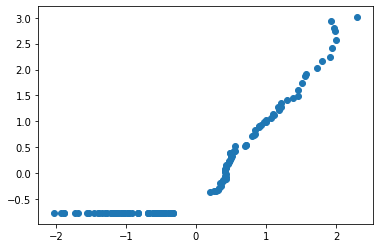

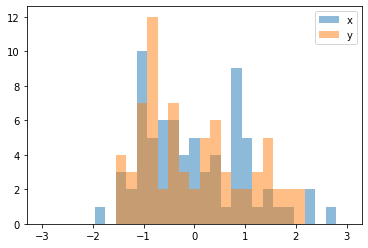

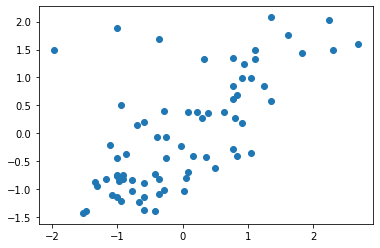

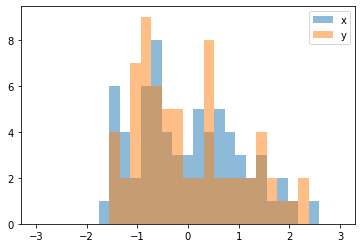

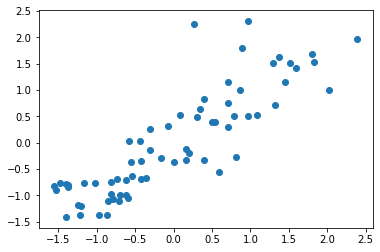

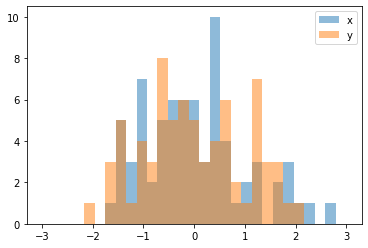

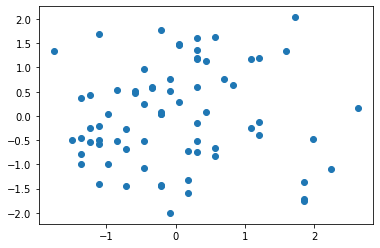

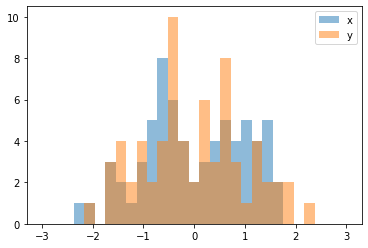

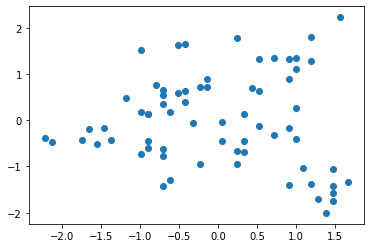

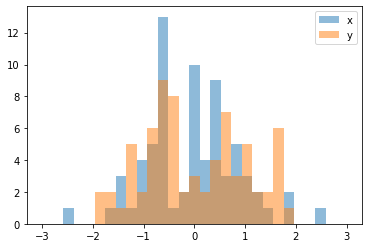

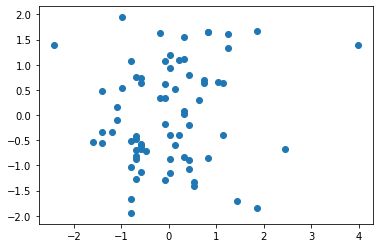

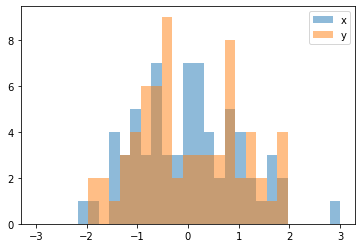

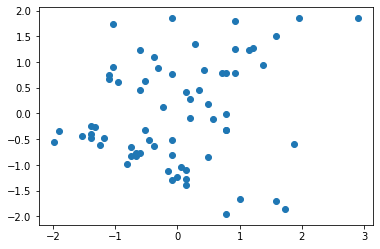

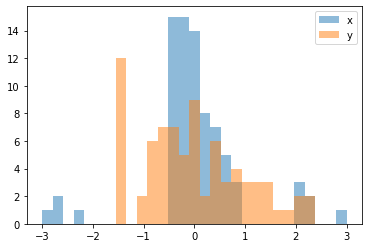

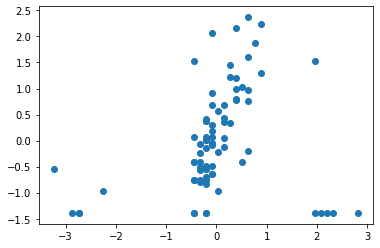

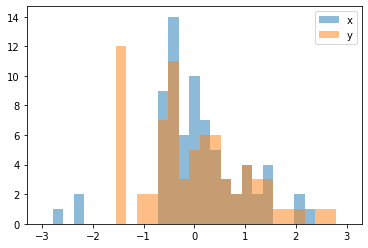

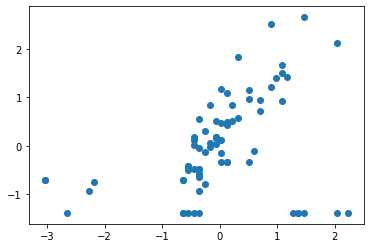

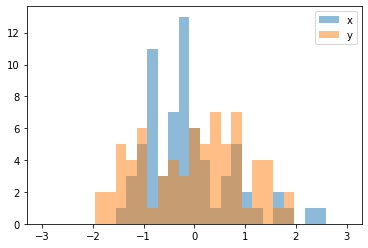

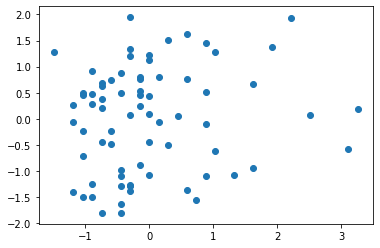

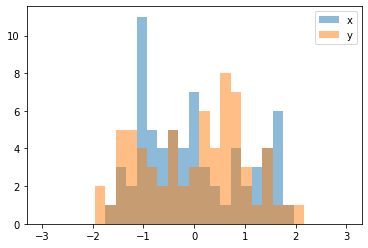

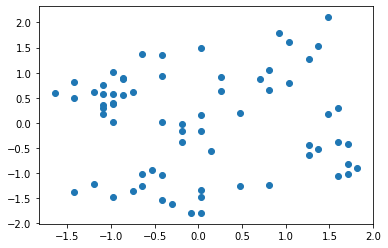

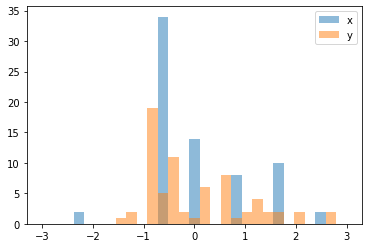

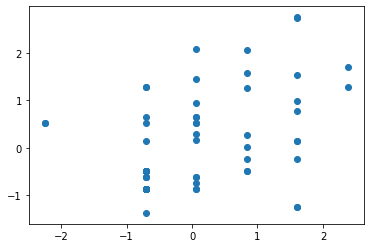

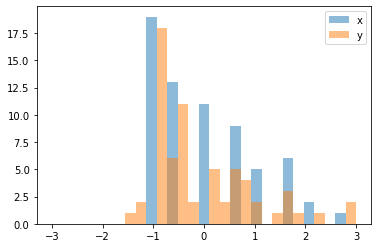

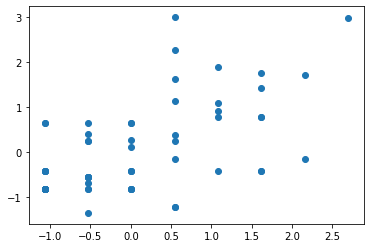

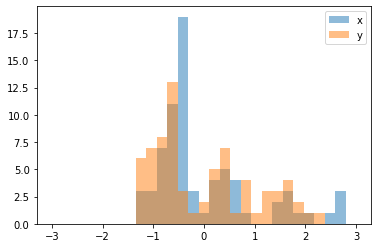

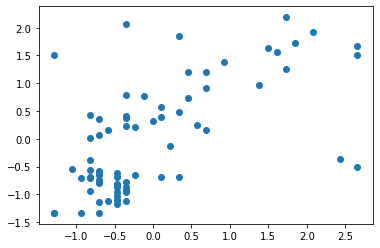

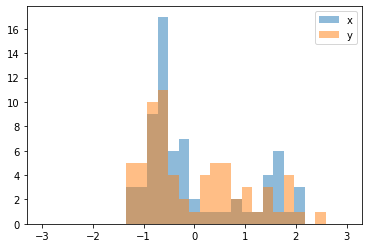

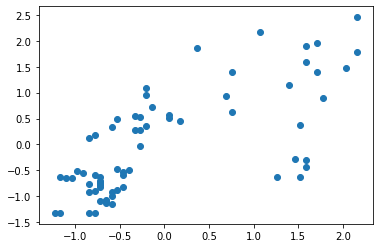

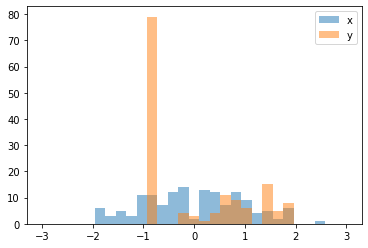

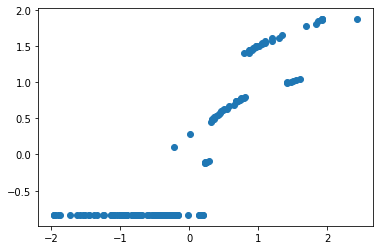

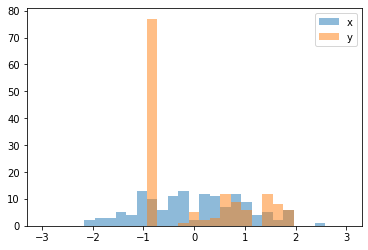

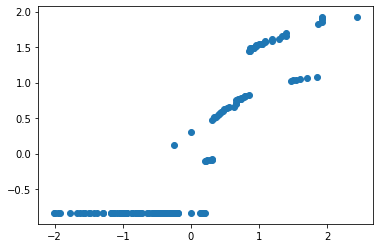

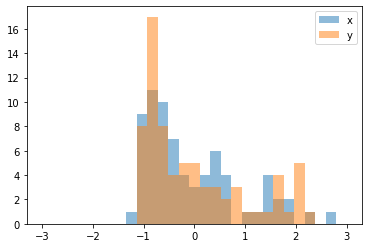

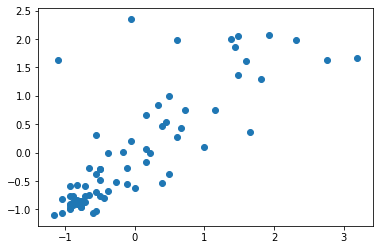

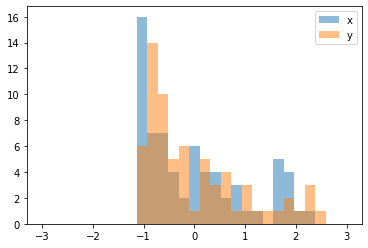

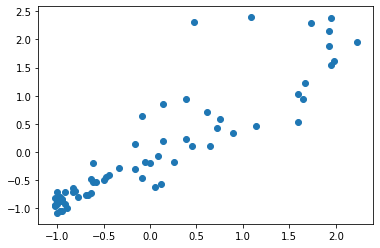

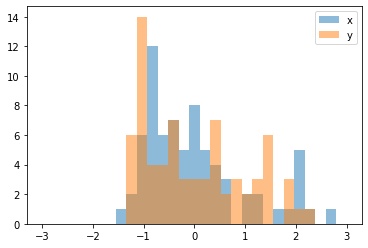

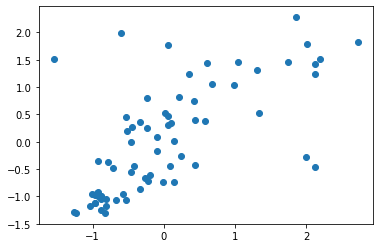

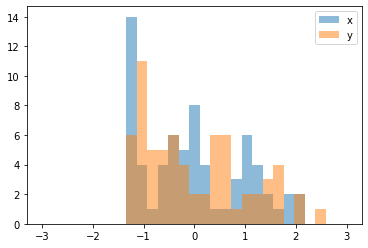

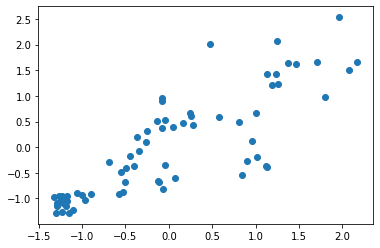

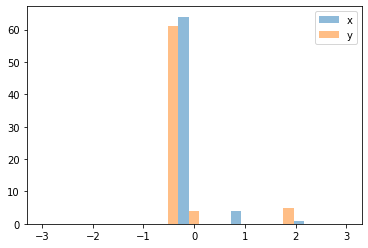

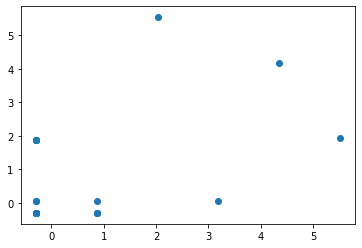

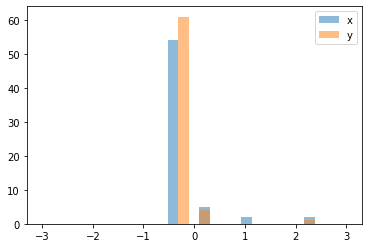

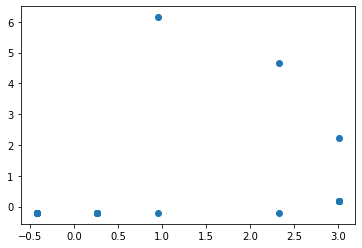

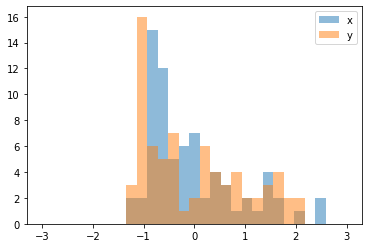

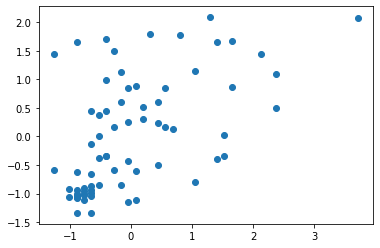

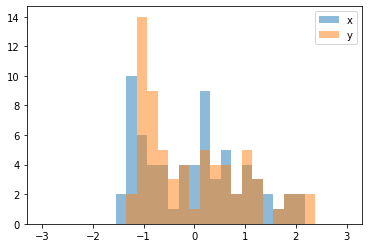

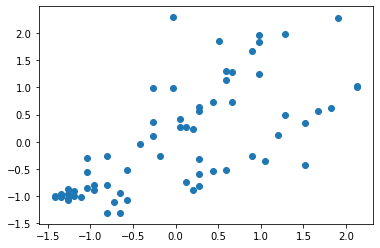

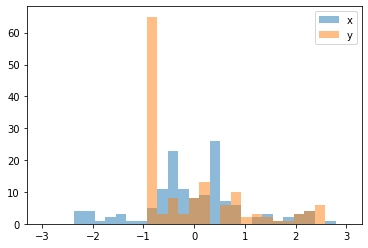

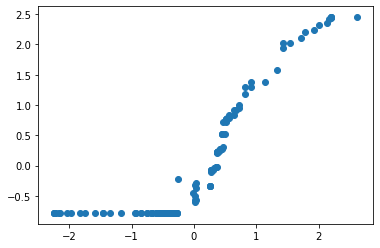

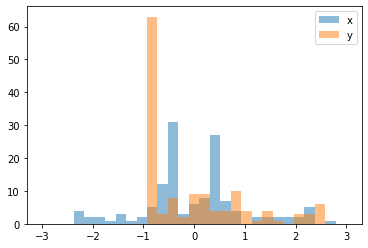

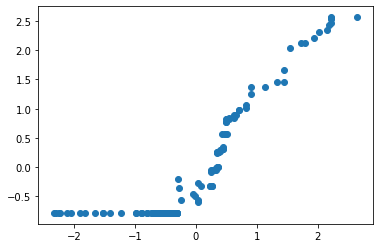

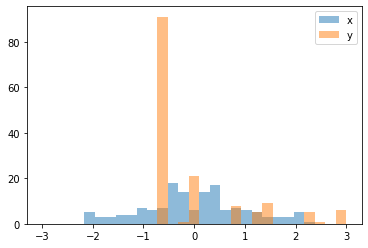

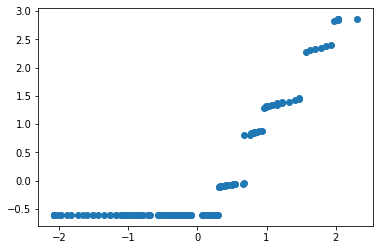

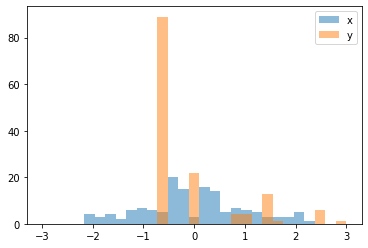

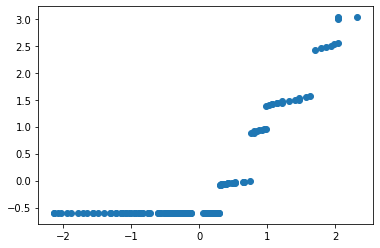

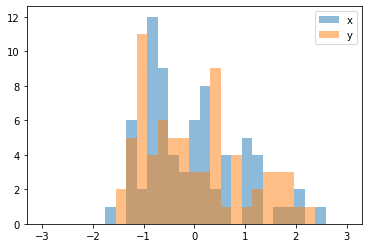

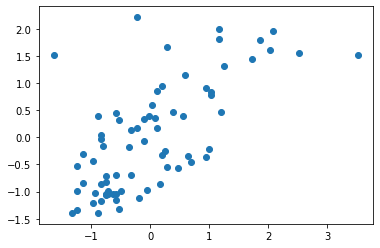

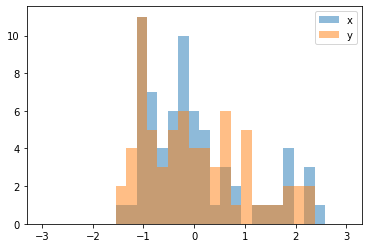

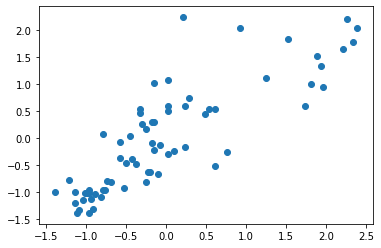

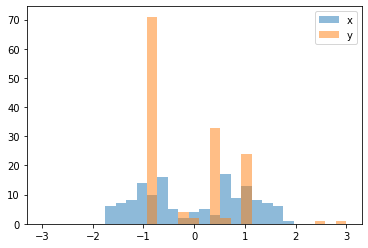

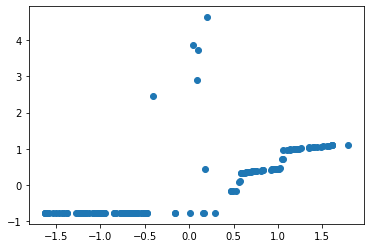

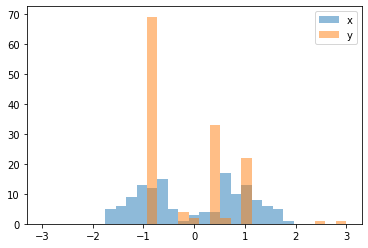

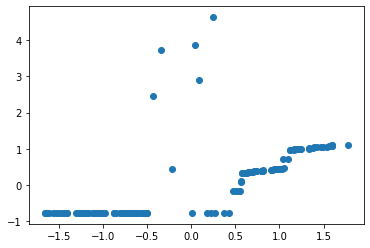

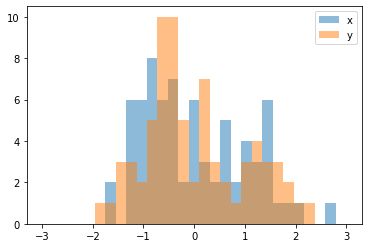

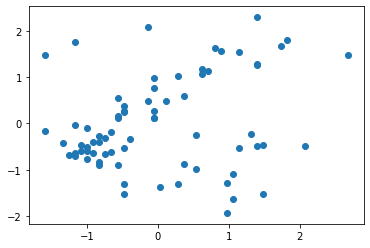

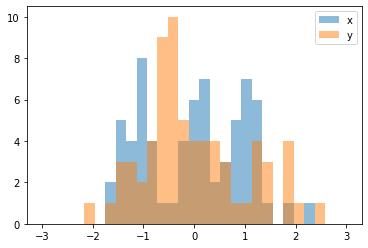

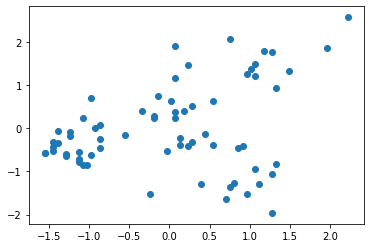

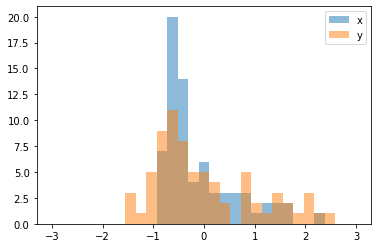

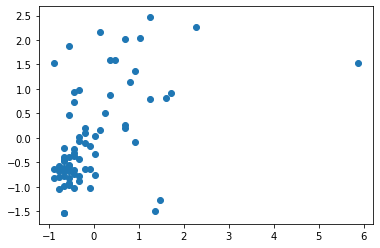

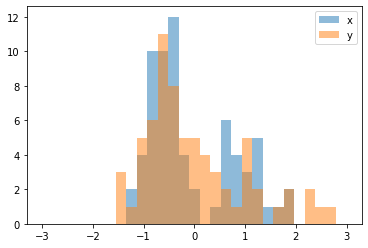

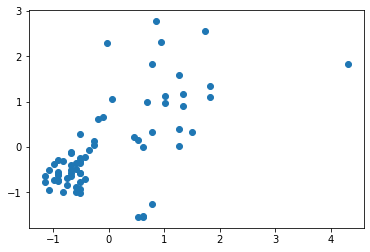

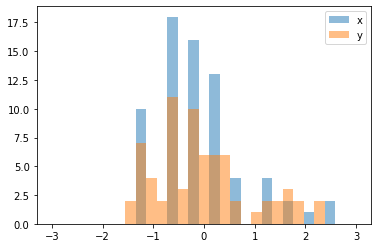

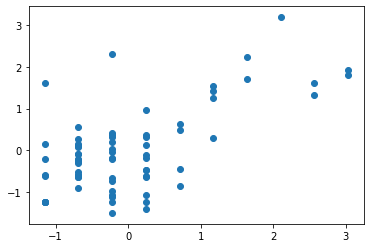

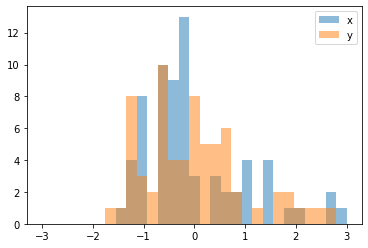

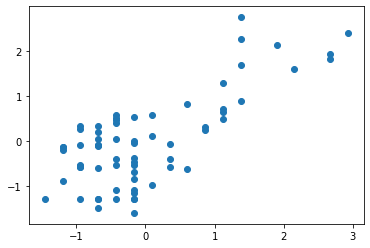

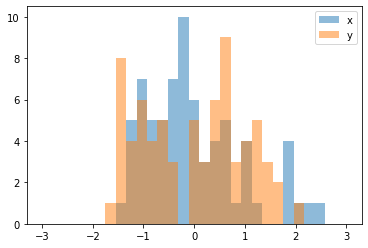

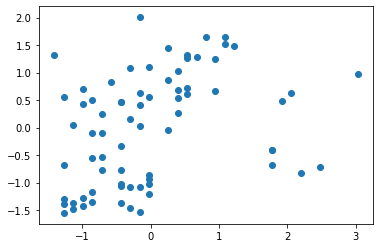

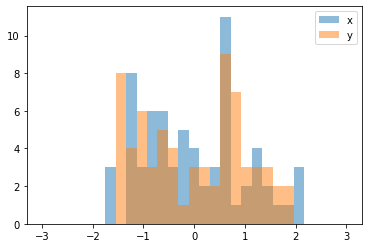

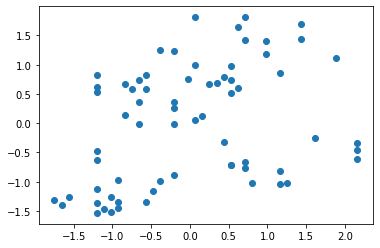

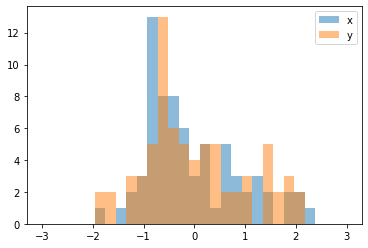

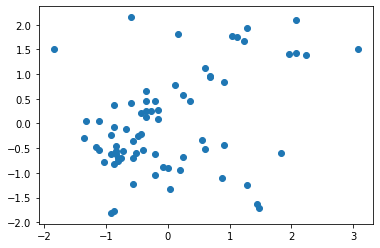

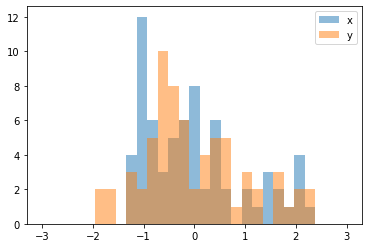

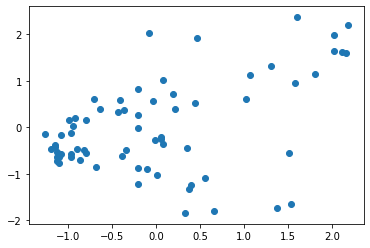

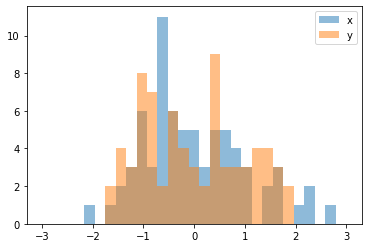

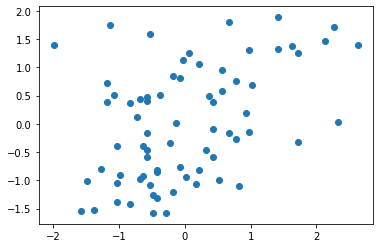

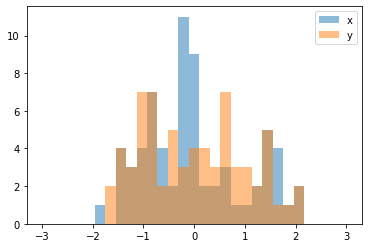

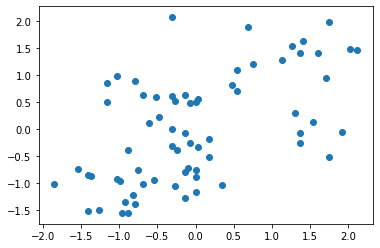

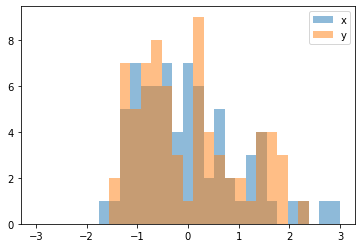

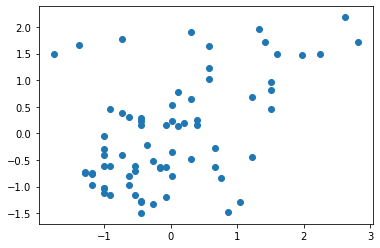

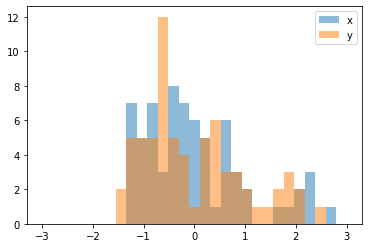

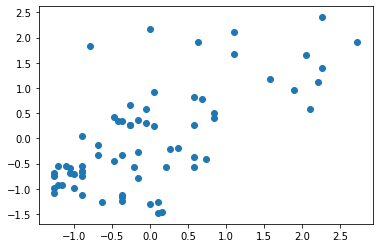

In [32]:
# Process usc risk evaluation
from ast import literal_eval

df_risk_usc = pd.read_csv('risk_USC.csv')
df_risk_usc[['cases', 'risk_score']] = df_risk_usc[['cases', 'risk_score']].applymap(literal_eval)
df_risk_usc['error_3'] = 0
df_risk_usc['error_7'] = 0
for index, row in df_risk_usc.iterrows():
    pop = row['locatpopulationion']
    case = np.array(row['cases'], dtype = 'float')
    risk = np.array(row['risk_score'], dtype = 'float')
    if sum(risk)==0:
        continue
    df_risk_usc.iloc[index, df_risk_usc.columns.get_loc('error_3')] = cal_error(3, case, risk)
    df_risk_usc.iloc[index, df_risk_usc.columns.get_loc('error_7')] = cal_error(7, case, risk)

In [15]:
df_risk_usc

,location,locatpopulationion,cases,risk_score,last_date,error_3,error_7
0,Norwalk,104868.0,"[88.0, 90.0, 93.0, 100.0, 105.0, 124.0, 135.0,...","[9.81418798861426, 10.702125158985583, 13.7077...",07/06/2020,0.696243,0.816593
1,Hawthorne,114032.0,"[87.0, 90.0, 89.0, 92.0, 94.0, 134.0, 140.0, 1...","[9.576742147519994, 7.240525881588877, 9.75317...",07/06/2020,0.905938,0.904522
2,El Segundo,26864.0,"[12.0, 12.0, 12.0, 14.0, 14.0, 21.0, 24.0, 25....","[4.46894086101594, 4.46894086101594, 9.6359674...",07/06/2020,0.328818,0.306889
3,Glendale,201605.0,"[278.0, 288.0, 310.0, 326.0, 332.0, 369.0, 389...","[17.468658563349123, 22.205062227782047, 21.21...",07/06/2020,-0.182697,-0.315188
4,Huntington Park,59508.0,"[44.0, 46.0, 52.0, 56.0, 58.0, 87.0, 95.0, 106...","[9.866484092458158, 14.850184205535394, 13.607...",07/06/2020,0.653603,0.841599
...,...,...,...,...,...,...,...
78,San Gabriel,40311.0,"[14.0, 15.0, 15.0, 16.0, 16.0, 23.0, 25.0, 26....","[5.2719835416759695, 3.7224538415723645, 5.524...",07/06/2020,0.345374,0.339872
79,Lancaster,169552.0,"[91.0, 96.0, 102.0, 114.0, 120.0, 184.0, 197.0...","[7.524320747303188, 8.2412056681608, 11.041255...",07/06/2020,0.377790,0.450446
80,Pico Rivera,64052.0,"[67.0, 73.0, 77.0, 79.0, 81.0, 107.0, 113.0, 1...","[17.207613759414222, 15.975568742439735, 14.35...",07/06/2020,0.432409,0.567674
81,Gardena,60679.0,"[82.0, 86.0, 93.0, 96.0, 102.0, 121.0, 126.0, ...","[18.366401729066066, 22.524125526409467, 19.00...",07/06/2020,0.504446,0.663306


In [18]:
df_risk_usc.to_csv("risk_usc_eval.csv")

In [19]:
# Process lmu risk evaluation

df_risk_lmu = pd.read_csv('risk_lmu_comp.csv')
df_risk_lmu[['cases', 'risk_score']] = df_risk_lmu[['cases', 'risk_score']].applymap(literal_eval)
df_risk_lmu['error_3'] = 0
df_risk_lmu['error_7'] = 0
for index, row in retrain_lmu.iterrows():
    pop = row['locatpopulationion']
    case = np.array(row['cases'], dtype = 'float')
    risk = np.array(row['risk_score'], dtype = 'float')
    if sum(risk)==0:
        continue
    df_risk_lmu.iloc[index, df_risk_lmu.columns.get_loc('error_3')] = cal_error(3, case, risk)
    df_risk_lmu.iloc[index, df_risk_lmu.columns.get_loc('error_7')] = cal_error(7, case, risk)

df_risk_lmu
df_risk_lmu.to_csv("risk_lmu_eval.csv")

D:\Anaconda\envs\py3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
D:\Anaconda\envs\py3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
D:\Anaconda\envs\py3\lib\site-packages\numpy\lib\function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
D:\Anaconda\envs\py3\lib\site-packages\numpy\lib\function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
